# 1. Import Libraries

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from xgboost import XGBRegressor
import datetime


## Dataset Variables Description

| Variable Name    | Role      | Type        | Description                                                                 | Units     | Missing Values |
|------------------|-----------|-------------|-----------------------------------------------------------------------------|-----------|----------------|
| Date             | Feature   | Date        | Date of the measurement                                                       | -         | no             |
| Time             | Feature   | Categorical | Time of the measurement                                                        | -         | no             |
| CO(GT)           | Feature   | Integer      | True hourly averaged concentration CO in mg/m³ (reference analyzer)          | mg/m³     | no             |
| PT08.S1(CO)      | Feature   | Categorical | Hourly averaged sensor response (nominally CO targeted)                       | -         | no             |
| NMHC(GT)         | Feature   | Integer      | True hourly averaged overall Non-Methanic Hydrocarbons concentration in µg/m³ (reference analyzer) | µg/m³    | no             |
| C6H6(GT)         | Feature   | Continuous   | True hourly averaged Benzene concentration in µg/m³ (reference analyzer)    | µg/m³     | no             |
| PT08.S2(NMHC)    | Feature   | Categorical | Hourly averaged sensor response (nominally NMHC targeted)                      | -         | no             |
| NOx(GT)          | Feature   | Integer      | True hourly averaged NOx concentration in ppb (reference analyzer)           | ppb       | no             |
| PT08.S3(NOx)     | Feature   | Categorical | Hourly averaged sensor response (nominally NOx targeted)                      | -         | no             |
| NO2(GT)          | Feature   | Integer      | True hourly averaged NO2 concentration in µg/m³ (reference analyzer)         | µg/m³     | no             |

Source link: https://archive.ics.uci.edu/dataset/360/air+quality

# 2. Load the Data

In [27]:
data = pd.read_csv('data/AirQualityUCI.csv', sep=';', decimal=',')
data.tail(5) 
data.shape

(9471, 17)

In [28]:
data.head(5)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


# 3. Data Preprocessing


In [30]:
# Replace invalid values with NaN
data.replace(-200, np.nan, inplace=True)

# Drop rows where 'Date' or 'Time' is missing
data.dropna(subset=['Date', 'Time'], inplace=True)
data


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,04/04/2005,10.00.00,3.1,1314.0,NaN,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568,NaN,NaN
9353,04/04/2005,11.00.00,2.4,1163.0,NaN,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119,NaN,NaN
9354,04/04/2005,12.00.00,2.4,1142.0,NaN,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406,NaN,NaN
9355,04/04/2005,13.00.00,2.1,1003.0,NaN,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139,NaN,NaN


# 4. Feature Engineering


In [31]:
# Correct the time format
data['Time'] = data['Time'].apply(lambda x: x.replace('.', ':'))

# Combine 'Date' and 'Time' into a single datetime column
data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], dayfirst=True)

data

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16,Datetime
0,10/03/2004,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN,2004-03-10 18:00:00
1,10/03/2004,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN,2004-03-10 19:00:00
2,10/03/2004,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN,2004-03-10 20:00:00
3,10/03/2004,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN,2004-03-10 21:00:00
4,10/03/2004,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN,2004-03-10 22:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,04/04/2005,10:00:00,3.1,1314.0,NaN,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568,NaN,NaN,2005-04-04 10:00:00
9353,04/04/2005,11:00:00,2.4,1163.0,NaN,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119,NaN,NaN,2005-04-04 11:00:00
9354,04/04/2005,12:00:00,2.4,1142.0,NaN,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406,NaN,NaN,2005-04-04 12:00:00
9355,04/04/2005,13:00:00,2.1,1003.0,NaN,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139,NaN,NaN,2005-04-04 13:00:00


In [ ]:
# Set 'Datetime' as the index
data.set_index('Datetime', inplace=True)

# Drop unnecessary columns
data.drop(['Date', 'Time', 'Unnamed: 15', 'Unnamed: 16'], axis=1, inplace=True)

# Fill missing values with the median of each column
data.fillna(data.median(), inplace=True)
# Optionally fill remaining missing values using forward fill
# data.fillna(method='ffill', inplace=True)


In [4]:
# Extract additional time-related features
data['Hour'] = data.index.hour
data['DayOfWeek'] = data.index.dayofweek
data['Month'] = data.index.month
data['Quarter'] = data.index.quarter


# 5. Train-Test Split


In [5]:
# Separate features and target variable
X = data.drop('CO(GT)', axis=1)
y = data['CO(GT)']

# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# 6. Scaling the Data


In [6]:
# Standardize the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# 7. Define Models


In [7]:
# Define a dictionary of models to be trained and evaluated
models = {
    "Linear Regression": LinearRegression(),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "Decision Tree": DecisionTreeRegressor(),
    "SVM": SVR(),
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "XGBoost": XGBRegressor(objective='reg:squarederror', n_estimators=100),
    "Ensemble": VotingRegressor([
        ('lr', LinearRegression()), 
        ('knn', KNeighborsRegressor()), 
        ('dt', DecisionTreeRegressor()),
        ('svr', SVR()), 
        ('rf', RandomForestRegressor()), 
        ('xgb', XGBRegressor(objective='reg:squarederror'))
    ])
}


# 8. Train and Evaluate Models


In [8]:
# Dictionary to store evaluation results
results = {}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    print(f'{name} - Mean Squared Error: {mse}, Mean Absolute Error: {mae}, R²: {r2}')


Linear Regression - Mean Squared Error: 0.41955000154280087, Mean Absolute Error: 0.4552310901299488, R²: 0.7664460368298764
KNN - Mean Squared Error: 0.4509036324786325, Mean Absolute Error: 0.4858440170940171, R²: 0.7489921821333945
Decision Tree - Mean Squared Error: 0.7221153846153846, Mean Absolute Error: 0.5838675213675214, R²: 0.5980147555169635
SVM - Mean Squared Error: 0.4920568559024535, Mean Absolute Error: 0.5284298559882568, R²: 0.7260831167239918
Random Forest - Mean Squared Error: 0.3938317291666667, Mean Absolute Error: 0.4241650641025641, R²: 0.7807628153240891
XGBoost - Mean Squared Error: 0.4199881824841501, Mean Absolute Error: 0.4497304280272598, R²: 0.7662021114453897
Ensemble - Mean Squared Error: 0.3827908105994674, Mean Absolute Error: 0.42664500469756816, R²: 0.7869090440904473


# 9. Display Results

In [9]:
# Display the evaluation results
results_df = pd.DataFrame(results).T
print(results_df)


                        MSE       MAE        R2
Linear Regression  0.419550  0.455231  0.766446
KNN                0.450904  0.485844  0.748992
Decision Tree      0.722115  0.583868  0.598015
SVM                0.492057  0.528430  0.726083
Random Forest      0.393832  0.424165  0.780763
XGBoost            0.419988  0.449730  0.766202
Ensemble           0.382791  0.426645  0.786909


# 10. Plot Residuals for the Best Model (Example: XGBoost)


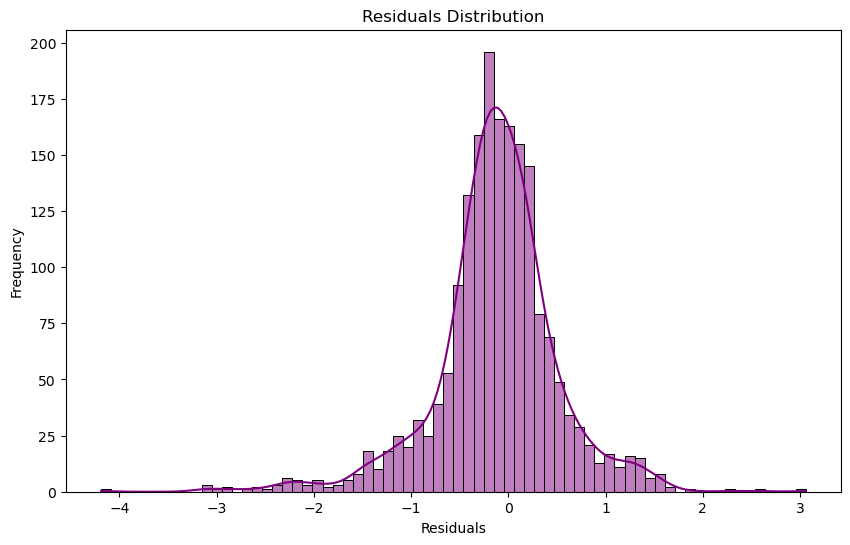

In [10]:
# Plot the distribution of residuals for the best model
plt.figure(figsize=(10, 6))
sns.histplot((y_test - models['XGBoost'].predict(X_test_scaled)), bins=70, color="purple", kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


# 10a. Plot Residuals for the Best Model (Example:SVN

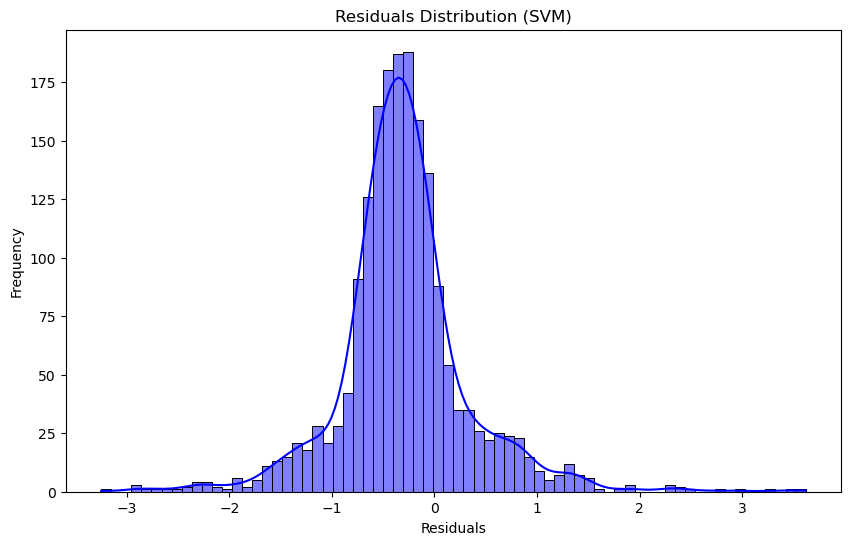

In [11]:
# Plot the distribution of residuals for the best model (Example: SVM)
plt.figure(figsize=(10, 6))
sns.histplot((y_test - models['SVM'].predict(X_test_scaled)), bins=70, color="blue", kde=True)
plt.title('Residuals Distribution (SVM)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


# 11. Forecasting  Plot  

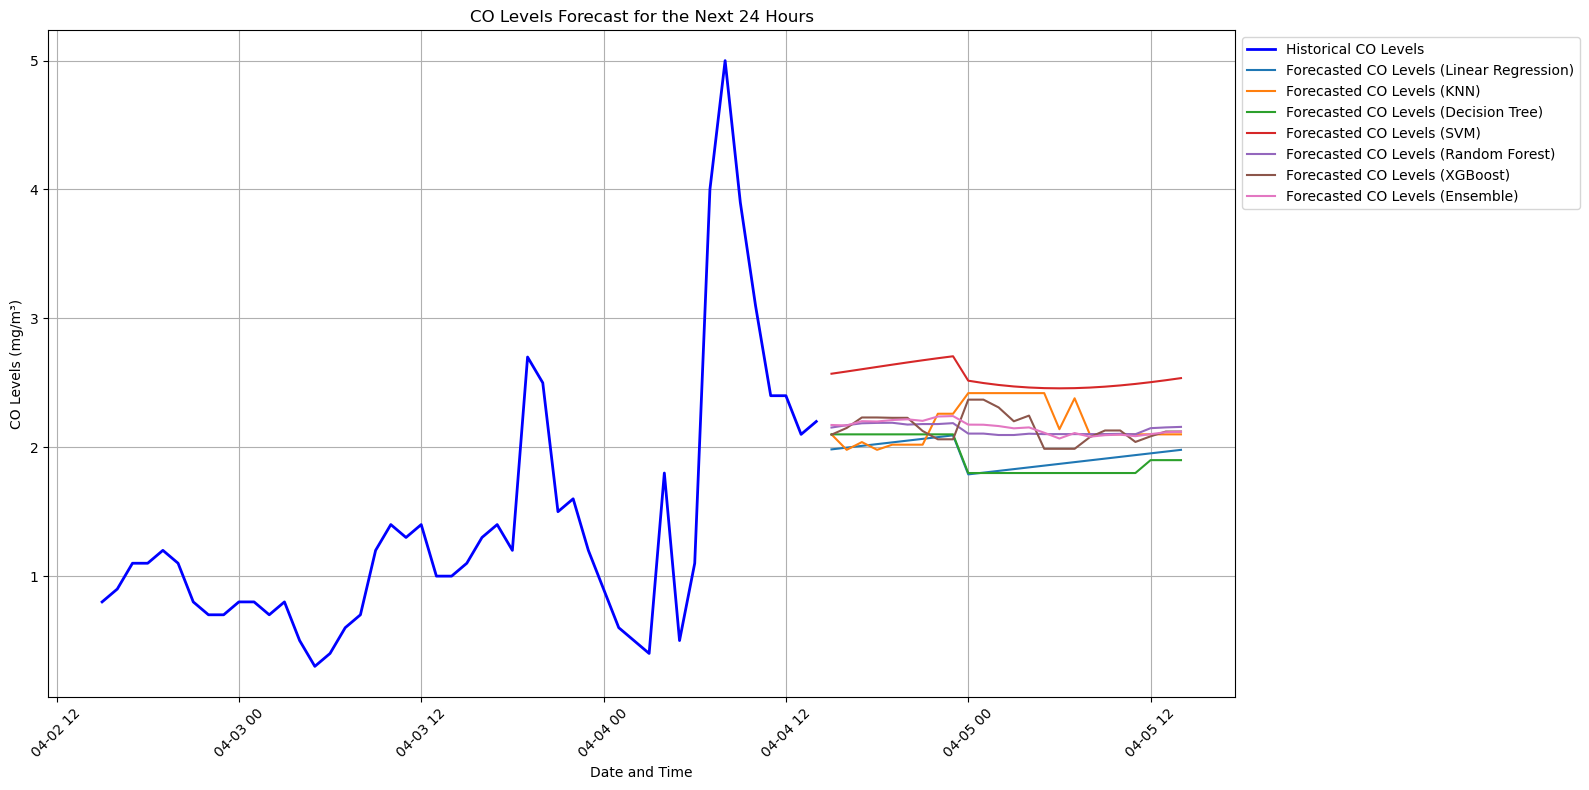

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

# Assuming 'data' is your DataFrame and 'scaler' is your StandardScaler instance

# Generate future dates for forecasting
future_dates = [data.index[-1] + datetime.timedelta(hours=i) for i in range(1, 25)]
future_df = pd.DataFrame(index=future_dates)

# Add time-related features for the future dates
future_df['Hour'] = future_df.index.hour
future_df['DayOfWeek'] = future_df.index.dayofweek
future_df['Month'] = future_df.index.month
future_df['Quarter'] = future_df.index.quarter

# Fill other feature columns with the latest available values
for col in X.columns.difference(future_df.columns):
    future_df[col] = data[col].iloc[-1]
future_df = future_df[X.columns]

# Scale the future data
future_scaled = scaler.transform(future_df)

# Plot historical and forecasted CO levels
plt.figure(figsize=(16, 8))

# Plot historical data
plt.plot(data.index[-48:], data['CO(GT)'].iloc[-48:], label='Historical CO Levels', color='blue', linewidth=2)

# Plot forecasted data for each model
for name, model in models.items():
    future_pred = model.predict(future_scaled)
    plt.plot(future_dates, future_pred, label=f'Forecasted CO Levels ({name})')

# Customize the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('CO Levels Forecast for the Next 24 Hours')
plt.xlabel('Date and Time')
plt.ylabel('CO Levels (mg/m³)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust plot to fit labels

# Display the plot
plt.show()



# 12. Interpret the Forecasted Values

### Prepare the future dates and the feature set for forecasting:



In [13]:
# Generate future dates for forecasting
future_dates = [data.index[-1] + datetime.timedelta(hours=i) for i in range(1, 25)]
future_df = pd.DataFrame(index=future_dates)

# Add time-related features for the future dates
future_df['Hour'] = future_df.index.hour
future_df['DayOfWeek'] = future_df.index.dayofweek
future_df['Month'] = future_df.index.month
future_df['Quarter'] = future_df.index.quarter

# Fill other feature columns with the latest available values
for col in X.columns.difference(future_df.columns):
    future_df[col] = data[col].iloc[-1]
future_df = future_df[X.columns]

# Scale the future data
future_scaled = scaler.transform(future_df)


### Forecast and Interpret Results

Generate forecasts for each model and summarize the results:

In [14]:
# Create a dictionary to store forecasts and their insights
forecast_summary = {
    "Model": [],
    "Average Forecast (mg/m^3)": [],
    "Max Forecast (mg/m^3)": [],
    "Min Forecast (mg/m^3)": [],
    "Interpretation": []
}

# Generate forecasts and insights for each model
for name, model in models.items():
    future_pred = model.predict(future_scaled)
    forecasted_values = pd.Series(future_pred, index=future_dates)
    
    # Calculate insights
    average_forecast = forecasted_values.mean()
    max_forecast = forecasted_values.max()
    min_forecast = forecasted_values.min()
    
    # Append results to summary
    forecast_summary["Model"].append(name)
    forecast_summary["Average Forecast (mg/m^3)"].append(average_forecast)
    forecast_summary["Max Forecast (mg/m^3)"].append(max_forecast)
    forecast_summary["Min Forecast (mg/m^3)"].append(min_forecast)
    
    # Interpretation
    if max_forecast > 10:
        interpretation = "Warning: The forecast indicates a potential spike in CO levels, which might be harmful to health."
    else:
        interpretation = "The forecasted CO levels are within a safe range."
    forecast_summary["Interpretation"].append(interpretation)

# Convert the summary dictionary to a DataFrame
forecast_summary_df = pd.DataFrame(forecast_summary)


### Display as  Table

In [15]:
# Display the forecast summary table
forecast_summary_df


,Model,Average Forecast (mg/m^3),Max Forecast (mg/m^3),Min Forecast (mg/m^3),Interpretation
0,Linear Regression,1.942114,2.092267,1.789474,The forecasted CO levels are within a safe range.
1,KNN,2.184167,2.420000,1.980000,The forecasted CO levels are within a safe range.
2,Decision Tree,1.925000,2.100000,1.800000,The forecasted CO levels are within a safe range.
3,SVM,2.542951,2.705958,2.457171,The forecasted CO levels are within a safe range.
4,Random Forest,2.137250,2.190000,2.095000,The forecasted CO levels are within a safe range.
5,XGBoost,2.149249,2.369433,1.987978,The forecasted CO levels are within a safe range.
6,Ensemble,2.152573,2.241819,2.067868,The forecasted CO levels are within a safe range.


## Summary of Forecasted CO Levels

- **All Models:** The forecasted CO levels across all models fall within the safe range. None of the models predict CO levels that exceed the threshold of 10 mg/m³. According to these forecasts, there is no immediate health risk from elevated CO levels in the next 24 hours.

- **Variation:** Although all models predict that CO levels will remain within safe limits, there is some variation in the predicted values. For example, the Support Vector Machine (SVM) predicts slightly higher CO levels compared to other models, but these levels are still within the safe range.

- **Average Levels:** Most models forecast average CO levels between 1.90 mg/m³ and 2.18 mg/m³. These values are well below the concerning threshold of 10 mg/m³.

- **Overall:** The results suggest a stable air quality forecast with no anticipated spikes in CO levels that would warrant health concerns.

- **Missing gap:** at the transition between the historical and  focast data   


# Here we can generalize by selecting each gas and make prediction 

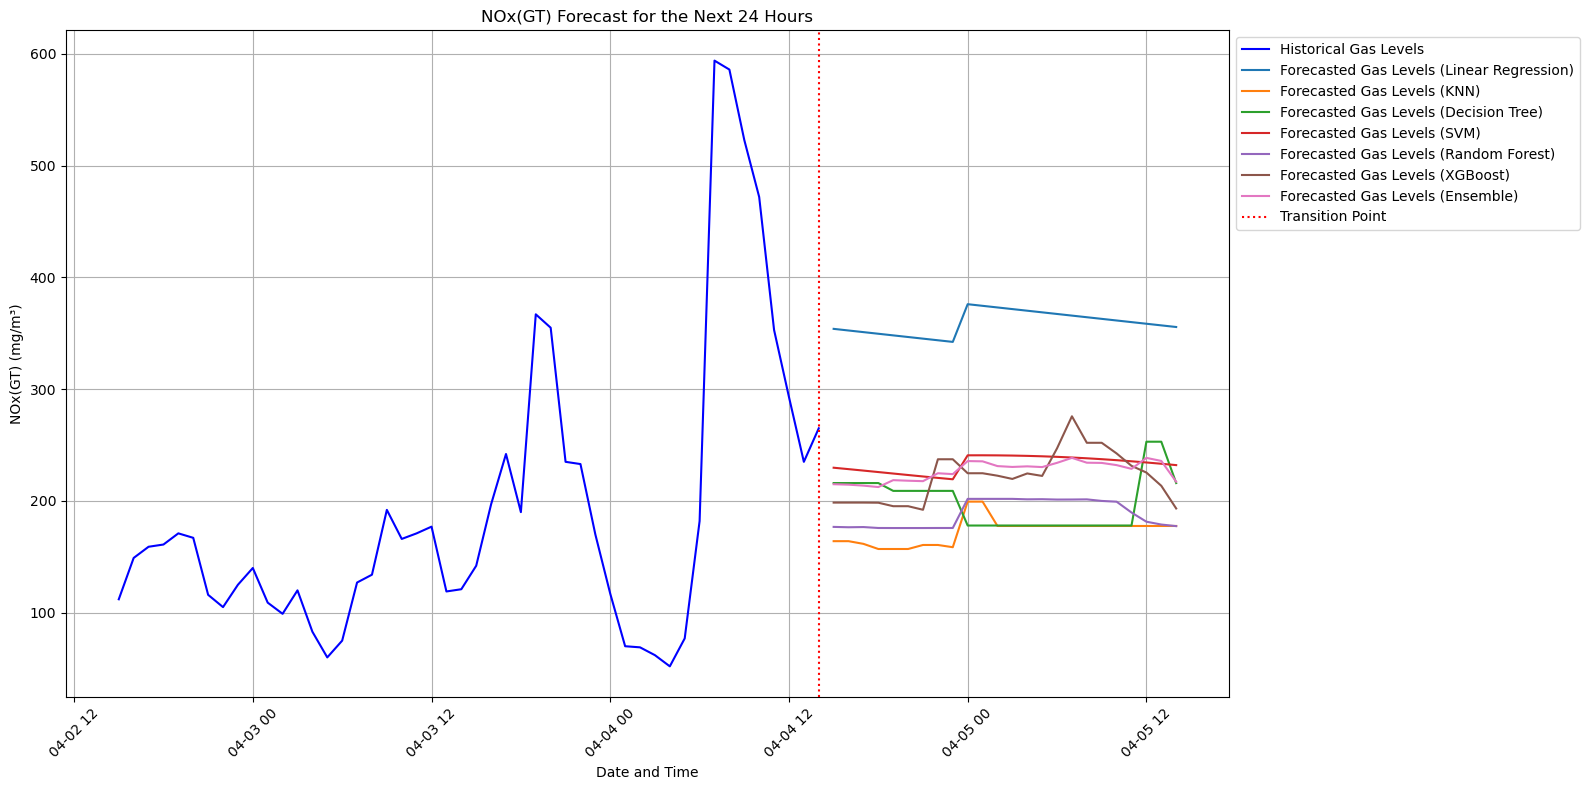

                            MSE         MAE        R2
Linear Regression   7438.281525   64.034156  0.826930
KNN                 6780.466624   57.366453  0.842236
Decision Tree      18759.620192   93.058226  0.563511
SVM                30798.485121  100.732494  0.283397
Random Forest      13610.474551   79.970844  0.683318
XGBoost             9361.873292   64.995908  0.782173
Ensemble            8563.182128   60.582325  0.800756
               Model  Average Forecast (mg/m³)  Max Forecast (mg/m³)  \
0  Linear Regression                359.206370            376.050043   
1                KNN                172.833333            199.400000   
2      Decision Tree                198.625000            253.000000   
3                SVM                232.904866            240.849947   
4      Random Forest                188.567917            201.850000   
5            XGBoost                221.795212            275.751923   
6           Ensemble                226.915375            238.53

In [16]:
# Select the gas for prediction
gas_column = 'NOx(GT)'  # Change this to the gas you want to predict

# Train-Test Split
X = data.drop(gas_column, axis=1)
y = data[gas_column]
train_size = int(len(data) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Scaling the Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define Models
models = {
    "Linear Regression": LinearRegression(),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "Decision Tree": DecisionTreeRegressor(),
    "SVM": SVR(),
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "XGBoost": XGBRegressor(objective='reg:squarederror', n_estimators=100),
    "Ensemble": VotingRegressor([
        ('lr', LinearRegression()), 
        ('knn', KNeighborsRegressor()), 
        ('dt', DecisionTreeRegressor()),
        ('svr', SVR()), 
        ('rf', RandomForestRegressor()), 
        ('xgb', XGBRegressor(objective='reg:squarederror'))
    ])
}

# Train and Forecast Models
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}

# Generate future dates for forecasting
future_dates = [data.index[-1] + datetime.timedelta(hours=i) for i in range(1, 25)]
future_df = pd.DataFrame(index=future_dates)

# Add time-related features for the future dates
future_df['Hour'] = future_df.index.hour
future_df['DayOfWeek'] = future_df.index.dayofweek
future_df['Month'] = future_df.index.month
future_df['Quarter'] = future_df.index.quarter

# Fill other feature columns with the latest available values
for col in X.columns.difference(future_df.columns):
    future_df[col] = data[col].iloc[-1]
future_df = future_df[X.columns]

# Scale the future data
future_scaled = scaler.transform(future_df)

# Plot historical and forecasted gas levels
plt.figure(figsize=(16, 8))

# Plot historical data
plt.plot(data.index[-48:], data[gas_column].iloc[-48:], label='Historical Gas Levels', color='blue', linestyle='-')

# Plot forecasted data for each model
for name, model in models.items():
    future_pred = model.predict(future_scaled)
    plt.plot(future_dates, future_pred, label=f'Forecasted Gas Levels ({name})')

# Add vertical line to indicate transition point
transition_date = data.index[-1]
plt.axvline(x=transition_date, color='red', linestyle=':', linewidth=1.5, label='Transition Point')

# Customize the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title(f'{gas_column} Forecast for the Next 24 Hours')
plt.xlabel('Date and Time')
plt.ylabel(f'{gas_column} (mg/m³)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust plot to fit labels

# Display the plot
plt.show()

# Display results
results_df = pd.DataFrame(results).T
print(results_df)

# Interpretation and Insights
forecast_summary = []
for name, model in models.items():
    future_pred = model.predict(future_scaled)
    forecast_summary.append({
        "Model": name,
        "Average Forecast (mg/m³)": np.mean(future_pred),
        "Max Forecast (mg/m³)": np.max(future_pred),
        "Min Forecast (mg/m³)": np.min(future_pred),
        "Interpretation": "Warning: The forecast indicates a potential spike in gas levels, which might be harmful to health." if np.max(future_pred) > 10 else "The forecasted gas levels are within a safe range."
    })

# Convert to DataFrame
forecast_summary_df = pd.DataFrame(forecast_summary)

# Display the summary table
print(forecast_summary_df)

In [17]:
forecast_summary_df 

,Model,Average Forecast (mg/m³),Max Forecast (mg/m³),Min Forecast (mg/m³),Interpretation
0,Linear Regression,359.206370,376.050043,342.311814,Warning: The forecast indicates a potential sp...
1,KNN,172.833333,199.400000,157.000000,Warning: The forecast indicates a potential sp...
2,Decision Tree,198.625000,253.000000,178.000000,Warning: The forecast indicates a potential sp...
3,SVM,232.904866,240.849947,219.384575,Warning: The forecast indicates a potential sp...
4,Random Forest,188.567917,201.850000,175.760000,Warning: The forecast indicates a potential sp...
5,XGBoost,221.795212,275.751923,192.098404,Warning: The forecast indicates a potential sp...
6,Ensemble,226.915375,238.531843,212.424621,Warning: The forecast indicates a potential sp...
